In [1]:
import numpy as np
import numpy.random as nprd
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils as utils
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as dsets
from torchvision import models
from torchvision.utils import save_image
from PIL import Image

from collections import OrderedDict

import cv2
import matplotlib.pyplot as plt

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import math
import time
import copy
import random as rd

device = torch.device('cuda')

###데이터 전처리
#난수 시드 설정
nprd.seed(2020)

#데이터 경로
root_dir = "./data/"
folders = [x for x in os.listdir(root_dir) if x != []]
files = [[x + "/" + y for y in os.listdir(root_dir + "/" + x)  if y not in
          ### 이상치 제외 및 손상된 파일 제외
          ['Afghan_hound_16.jpg',
           'Afghan_hound_25.jpg',
           'basenji_8.jpg',
           'Blenheim_spaniel_3.jpg',
           'borzoi_4.jpg',
           'black-and-tan_coonhound_3.jpg',
           'black-and-tan_coonhound_20.jpg',
           'black-and-tan_coonhound_131',
           'clumber_64.jpg',
           'clumber_75.jpg',
           'dingo_0.jpg',
           'EntleBucher_2.jpg',
           'Leonberg_2.jpg',
           'Norwegian_elkhound_186.jpg',
           'Norwegian_elkhound_177.jpg',
           'otterhound_3.jpg',
           'otterhound_149.jpg',
           'Pomeranian_184.jpg',
           'Pomeranian_162.jpg',
           'pug_3.jpg',
           'pug_4.jpg',
           'Shih-Tzu_132.jpg',
           'Shih-Tzu_189.jpg',
           'Siberian_husky_4.jpg',
           'Siberian_husky_179.jpg',
           'silky_terrier_2.jpg',
           'silky_terrier_185.jpg',
           'toy_poodle_4.jpg',
           'toy_poodle_130.jpg',
           'toy_poodle_132.jpg',
           'toy_terrier_1.jpg',
           'toy_terrier_59.jpg',
           'toy_terrier_106.jpg',
           'toy_terrier_116.jpg',
           'toy_terrier_148.jpg',
          ]] for x in folders]

transform_load = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_set = []
valid_set = []
test_set = []
train_lab = []
valid_lab = []
test_lab = []

for ind, class_files in enumerate(files):
    size = len(class_files)
    nprd.shuffle(class_files)
    sep1 = int(size * 0.7)
    sep2 = int(size * 0.8)
    train_sep = class_files[:sep1]
    for file_ind, img_files in enumerate(train_sep):
        img = Image.open(root_dir + img_files)
        train_set.append(img)
        train_lab.append(ind)
    
    valid_sep = class_files[sep1:sep2]
    for file_ind, img_files in enumerate(valid_sep):
        img = Image.open(root_dir + img_files)
        valid_set.append(img)
        valid_lab.append(ind)

    test_sep = class_files[sep2:]
    for file_ind, img_files in enumerate(test_sep):
        img = Image.open(root_dir + img_files)
        test_set.append(img)
        test_lab.append(ind)

#데이터 어그멘테이션을 Online 방식으로 적용.
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((256,256), scale = (0.8, 1.2)),
    transforms.RandomAffine(30),
    transforms.ColorJitter(brightness=(0.75, 1.25), 
                               contrast=(0.75, 1.25), 
                               saturation=(0.75, 1.25), 
                               hue=(-0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


transform_valid = transforms.Compose([
    transforms.RandomResizedCrop((256,256), scale = (0.8, 1.2)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop((256,256), scale = (0.8, 1.2)),
    transforms.ToTensor(),
])

class dog_data(torch.utils.data.Dataset):
    def __init__(self, imgs, labs, transform=None):
        self.imgs = imgs
        self.labs = labs
        self.len = len(labs)
        self.transform = transform
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.imgs[idx]), self.labs[idx]
        else:
            return self.imgs[idx], self.labs[idx]
        
train_dset = dog_data(train_set, train_lab, transform_train)
valid_dset = dog_data(valid_set, valid_lab, transform_valid)
test_dset = dog_data(test_set, test_lab, transform_test)

#Cyclic Learning Rate Scheduling을 위해 각 step마다 learning rate를 계산해주는 함수
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):
    scaler = lambda x: 1.
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

#라벨 스무딩을 적용하여 Cross Entropy loss를 계산해주는 모듈
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
#pytorch 데이터로더 선언
batch_size = 32
trainloader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=True, num_workers=0)

#라벨 스무딩 손실 함수, 일반적인 크로스 엔트로피 손실 함수
Smoothed_loss = LabelSmoothingLoss(classes=25, smoothing=0.1)
CE_loss = nn.CrossEntropyLoss()

In [2]:
#모델 아키텍쳐 불러오기
model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b2', pretrained=True).cuda()
#모델 구조 수정(마지막 레이어)
model.classifier = nn.Linear(1408, 25, bias = True).to(device)

#학습 관련 파라미터, Cyclic Learning rate Scheduler 선언
epoch = 50
clr = cyclical_lr(2*len(trainloader), min_lr=1e-2, max_lr=1e-1)
optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

train_loss_list = []
valid_loss_list = []
min_valid_loss = 1.0

#학습 진행
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    for ind, data in enumerate(trainloader):
        optimizer.zero_grad()
        img, label = data
        pred = model(img.cuda())
        #loss = CE_loss(pred, label.cuda())
        loss = Smoothed_loss(pred, label.cuda())
        train_loss += loss.detach() * img.shape[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_loss /= len(train_dset)
    train_loss_list.append(train_loss)
    
    #Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        acc = 0.0
        for ind, data in enumerate(validloader):
            img, label = data
            pred = model(img.cuda())
            valid_loss += CE_loss(pred, label.cuda()).detach() * img.shape[0]
            acc += sum(pred.argmax(1) == label.cuda()).item()
        valid_loss /= len(valid_dset)
        valid_loss_list.append(valid_loss)
        acc /= len(valid_dset)
        
        if valid_loss < min_valid_loss:
            best_model_state_dict = {k:v.to('cpu') for k, v in model.state_dict().items()}
            best_model_state_dict = OrderedDict(best_model_state_dict)
            min_valid_loss = valid_loss
            
    print("epoch : %d, train loss = %5.9f, valid loss = %5.9f, acc = %.3f, time: %f sec"
          %(run, train_loss, valid_loss, acc, time.time() - start))

Using cache found in C:\Users\KJH/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


epoch : 0, train loss = 1.430311084, valid loss = 0.617388070, acc = 0.855, time: 93.405544 sec
epoch : 1, train loss = 1.223909259, valid loss = 1.404835224, acc = 0.612, time: 84.937302 sec
epoch : 2, train loss = 1.280206680, valid loss = 0.492579490, acc = 0.874, time: 83.309417 sec
epoch : 3, train loss = 0.870481551, valid loss = 0.340451092, acc = 0.936, time: 83.342292 sec
epoch : 4, train loss = 0.761341929, valid loss = 0.353704035, acc = 0.921, time: 84.061291 sec
epoch : 5, train loss = 0.781256914, valid loss = 0.506258905, acc = 0.895, time: 84.865299 sec
epoch : 6, train loss = 0.811840236, valid loss = 0.426787198, acc = 0.912, time: 83.574291 sec
epoch : 7, train loss = 0.728922367, valid loss = 0.362204939, acc = 0.929, time: 84.190295 sec
epoch : 8, train loss = 0.693912268, valid loss = 0.352143228, acc = 0.938, time: 83.195291 sec
epoch : 9, train loss = 0.694887221, valid loss = 0.365703970, acc = 0.914, time: 83.775291 sec
epoch : 10, train loss = 0.714331925, va

In [3]:
#러닝레이트를 줄여서 다시 학습
epoch = 50
clr = cyclical_lr(2*len(trainloader), min_lr=1e-4, max_lr=1e-2)
optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

#학습 진행
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    for ind, data in enumerate(trainloader):
        optimizer.zero_grad()
        img, label = data
        pred = model(img.cuda())
        #loss = CE_loss(pred, label.cuda())
        loss = Smoothed_loss(pred, label.cuda())
        train_loss += loss.detach() * img.shape[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_loss /= len(train_dset)
    train_loss_list.append(train_loss)
    
    #Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        acc = 0.0
        for ind, data in enumerate(validloader):
            img, label = data
            pred = model(img.cuda())
            valid_loss += CE_loss(pred, label.cuda()).detach() * img.shape[0]
            acc += sum(pred.argmax(1) == label.cuda()).item()
        valid_loss /= len(valid_dset)
        valid_loss_list.append(valid_loss)
        acc /= len(valid_dset)
        
        if valid_loss < min_valid_loss:
            best_model_state_dict = {k:v.to('cpu') for k, v in model.state_dict().items()}
            best_model_state_dict = OrderedDict(best_model_state_dict)
            min_valid_loss = valid_loss
            
    print("epoch : %d, train loss = %5.9f, valid loss = %5.9f, acc = %.3f, time: %f sec"
          %(run, train_loss, valid_loss, acc, time.time() - start))

epoch : 0, train loss = 0.650130451, valid loss = 0.328375012, acc = 0.948, time: 82.237246 sec
epoch : 1, train loss = 0.648755848, valid loss = 0.302355587, acc = 0.950, time: 82.290247 sec
epoch : 2, train loss = 0.648222446, valid loss = 0.320609659, acc = 0.948, time: 81.991243 sec
epoch : 3, train loss = 0.649324059, valid loss = 0.326394439, acc = 0.940, time: 82.103247 sec
epoch : 4, train loss = 0.648820281, valid loss = 0.326009512, acc = 0.950, time: 82.403247 sec
epoch : 5, train loss = 0.647936702, valid loss = 0.331128389, acc = 0.943, time: 81.984245 sec
epoch : 6, train loss = 0.649033725, valid loss = 0.310014188, acc = 0.950, time: 82.223247 sec
epoch : 7, train loss = 0.648120582, valid loss = 0.323316097, acc = 0.952, time: 82.558248 sec
epoch : 8, train loss = 0.647882044, valid loss = 0.321920544, acc = 0.948, time: 82.020247 sec
epoch : 9, train loss = 0.648105979, valid loss = 0.322284371, acc = 0.948, time: 82.282246 sec
epoch : 10, train loss = 0.647621095, va

In [4]:
#러닝레이트를 줄여서 다시 학습
epoch = 50
clr = cyclical_lr(2*len(trainloader), min_lr=1e-6, max_lr=1e-4)
optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

#학습 진행
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    for ind, data in enumerate(trainloader):
        optimizer.zero_grad()
        img, label = data
        pred = model(img.cuda())
        #loss = CE_loss(pred, label.cuda())
        loss = Smoothed_loss(pred, label.cuda())
        train_loss += loss.detach() * img.shape[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_loss /= len(train_dset)
    train_loss_list.append(train_loss)
    
    #Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        acc = 0.0
        for ind, data in enumerate(validloader):
            img, label = data
            pred = model(img.cuda())
            valid_loss += CE_loss(pred, label.cuda()).detach() * img.shape[0]
            acc += sum(pred.argmax(1) == label.cuda()).item()
        valid_loss /= len(valid_dset)
        valid_loss_list.append(valid_loss)
        acc /= len(valid_dset)
        
        if valid_loss < min_valid_loss:
            best_model_state_dict = {k:v.to('cpu') for k, v in model.state_dict().items()}
            best_model_state_dict = OrderedDict(best_model_state_dict)
            min_valid_loss = valid_loss
            
    print("epoch : %d, train loss = %5.9f, valid loss = %5.9f, acc = %.3f, time: %f sec"
          %(run, train_loss, valid_loss, acc, time.time() - start))

epoch : 0, train loss = 0.646904528, valid loss = 0.318703204, acc = 0.948, time: 82.102278 sec
epoch : 1, train loss = 0.646688998, valid loss = 0.312162817, acc = 0.952, time: 82.009279 sec
epoch : 2, train loss = 0.646984875, valid loss = 0.318434149, acc = 0.948, time: 82.049279 sec
epoch : 3, train loss = 0.646747351, valid loss = 0.321510136, acc = 0.950, time: 82.466282 sec
epoch : 4, train loss = 0.646649897, valid loss = 0.318630219, acc = 0.943, time: 82.102047 sec
epoch : 5, train loss = 0.646908045, valid loss = 0.320736051, acc = 0.943, time: 81.892780 sec
epoch : 6, train loss = 0.646861553, valid loss = 0.310226202, acc = 0.950, time: 82.310957 sec
epoch : 7, train loss = 0.646768987, valid loss = 0.318917811, acc = 0.943, time: 82.107871 sec
epoch : 8, train loss = 0.647234261, valid loss = 0.323490530, acc = 0.945, time: 81.944802 sec
epoch : 9, train loss = 0.647185862, valid loss = 0.324644983, acc = 0.948, time: 81.865769 sec
epoch : 10, train loss = 0.646748543, va

In [5]:
#러닝레이트를 줄여서 다시 학습
epoch = 50
clr = cyclical_lr(2*len(trainloader), min_lr=1e-10, max_lr=1e-6)
optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

#학습 진행
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    for ind, data in enumerate(trainloader):
        optimizer.zero_grad()
        img, label = data
        pred = model(img.cuda())
        #loss = CE_loss(pred, label.cuda())
        loss = Smoothed_loss(pred, label.cuda())
        train_loss += loss.detach() * img.shape[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_loss /= len(train_dset)
    train_loss_list.append(train_loss)
    
    #Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        acc = 0.0
        for ind, data in enumerate(validloader):
            img, label = data
            pred = model(img.cuda())
            valid_loss += CE_loss(pred, label.cuda()).detach() * img.shape[0]
            acc += sum(pred.argmax(1) == label.cuda()).item()
        valid_loss /= len(valid_dset)
        valid_loss_list.append(valid_loss)
        acc /= len(valid_dset)
        
        if valid_loss < min_valid_loss:
            best_model_state_dict = {k:v.to('cpu') for k, v in model.state_dict().items()}
            best_model_state_dict = OrderedDict(best_model_state_dict)
            min_valid_loss = valid_loss
            
    print("epoch : %d, train loss = %5.9f, valid loss = %5.9f, acc = %.3f, time: %f sec"
          %(run, train_loss, valid_loss, acc, time.time() - start))

epoch : 0, train loss = 0.646779060, valid loss = 0.310709089, acc = 0.957, time: 82.108579 sec
epoch : 1, train loss = 0.646705210, valid loss = 0.313237488, acc = 0.952, time: 82.475602 sec
epoch : 2, train loss = 0.646860242, valid loss = 0.324532539, acc = 0.945, time: 82.205587 sec
epoch : 3, train loss = 0.646848500, valid loss = 0.313387662, acc = 0.948, time: 82.239591 sec
epoch : 4, train loss = 0.647162139, valid loss = 0.317062110, acc = 0.948, time: 82.164585 sec
epoch : 5, train loss = 0.646416962, valid loss = 0.316269368, acc = 0.945, time: 82.139580 sec
epoch : 6, train loss = 0.647066116, valid loss = 0.320522189, acc = 0.945, time: 82.085580 sec
epoch : 7, train loss = 0.646795332, valid loss = 0.322517365, acc = 0.948, time: 81.890569 sec
epoch : 8, train loss = 0.646623015, valid loss = 0.319210261, acc = 0.943, time: 82.090581 sec
epoch : 9, train loss = 0.646905541, valid loss = 0.322310030, acc = 0.943, time: 82.124583 sec
epoch : 10, train loss = 0.646604896, va

In [7]:
#모델 저장하기
if min_valid_loss != 1.0:
    model.load_state_dict(best_model_state_dict)
torch.save(model.state_dict(), "./save/hw2_0")

In [2]:
#저장된 모델 불러오기
model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b2').cuda()
model.classifier = nn.Linear(1408, 25, bias = True).to(device)
model.load_state_dict(torch.load("./save/hw2_0"))

Using cache found in C:\Users\KJH/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


<All keys matched successfully>

In [6]:
model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b2').cuda()
model.classifier = nn.Linear(1408, 25, bias = True).to(device)
model.load_state_dict(torch.load("./save/hw2_0"))

classwise_res = {ind:[0.0, 0] for ind in range(25)}
duplicates = 10 #한 이미지당 어그멘테이션을 적용하고 10번씩 정확도를 계산해서 평균냄

with torch.no_grad():
    acc = 0.0
    for duplicate in range(duplicates):
        for ind, data in enumerate(testloader):
            img, label = data
            pred = model(img.cuda())
            correct = (pred.argmax(1) == label.cuda())
            acc += sum(correct).item()
            for ex_ind, ex in enumerate(correct):
                if ex == 1.0:
                    classwise_res[int(label[ex_ind])][0] += 1.0
                classwise_res[int(label[ex_ind])][1] += 1
    acc /= len(test_dset) * duplicates
    
for ind in range(25):
    classwise_res[ind][0] /= classwise_res[ind][1]
    classwise_res[ind][1] /= duplicates

print("Total Accuracy: %.3f" %(acc))
for ind in range(25):
    print("Accuracy of %s(n=%d): %.3f" %(folders[ind], classwise_res[ind][1], classwise_res[ind][0]))

Total Accuracy: 0.936
Accuracy of Afghan_hound(n=36): 0.917
Accuracy of African_hunting_dog(n=32): 0.972
Accuracy of basenji(n=34): 0.979
Accuracy of black-and-tan_coonhound(n=33): 0.964
Accuracy of Blenheim_spaniel(n=36): 1.000
Accuracy of borzoi(n=26): 0.923
Accuracy of Chihuahua(n=30): 0.733
Accuracy of clumber(n=28): 1.000
Accuracy of dingo(n=30): 0.937
Accuracy of EntleBucher(n=40): 0.975
Accuracy of keeshond(n=32): 0.953
Accuracy of komondor(n=28): 0.971
Accuracy of Leonberg(n=33): 1.000
Accuracy of Maltese_dog(n=45): 0.936
Accuracy of Norwegian_elkhound(n=39): 0.946
Accuracy of otterhound(n=30): 0.873
Accuracy of Pomeranian(n=39): 0.949
Accuracy of pug(n=32): 0.906
Accuracy of Shih-Tzu(n=39): 0.879
Accuracy of Siberian_husky(n=36): 0.919
Accuracy of silky_terrier(n=38): 0.971
Accuracy of standard_schnauzer(n=32): 0.966
Accuracy of toy_poodle(n=26): 0.912
Accuracy of toy_terrier(n=34): 0.856
Accuracy of Welsh_springer_spaniel(n=31): 0.932


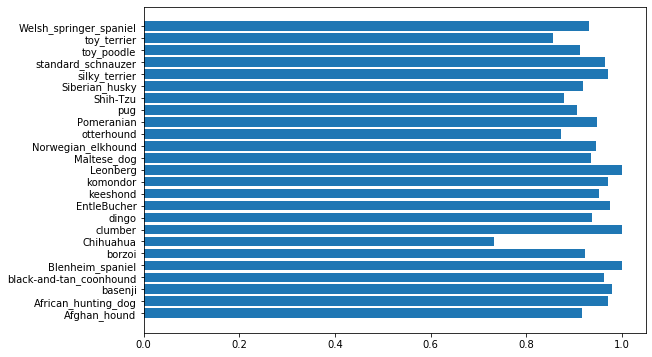

In [8]:
plt.figure(figsize = (9, 6))
plt.barh(list(range(25)), [x[0] for x in classwise_res.values()])
plt.yticks(list(range(25)), folders, rotation=0)
plt.show()

In [ ]:
#Stochastic Weight Averaging을 위해 저장한 모델 불러오기 - 메모리를 많이 요구하므로 모델을 CPU에 불러옴
model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b2')
model.classifier = nn.Linear(1408, 25, bias = True)
model.load_state_dict(torch.load("./save/hw2_0"))

#Stochastic Weight Averaging
optim = torch.optim.SGD(model.parameters(), lr=0.1)
params = []
for iter_ind in range(100):
    optim.zero_grad()
    for ind, data in enumerate(trainloader):
        img, label = data
        loss = CE_loss(model(img), label)
        loss.backward(retain_graph=True)
        optim.step()
    params.append(model.state_dict())
    print(iter_ind)

mean_model_dict = {}
for key in params[0].heys():
    mean_model_dict[key] = torch.mean(torch.stack([params[ind][key] for ind in range(10)]), dim=0)

#모델 저장하기
torch.save(model.state_dict(), "./save/hw2_swa_0")

Using cache found in C:\Users\KJH/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [ ]:
model.load_state_dict(torch.load("./save/hw2_swa_0"))

classwise_res = {ind:[0.0, 0] for ind in range(25)}
duplicates = 10

with torch.no_grad():
    test_loss = 0.0
    acc = 0.0
    for duplicate in range(duplicates):
        for ind, data in enumerate(testloader):
            img, label = data
            pred = model(img.cuda())
            correct = (pred.argmax(1) == label.cuda())
            acc += sum(correct).item()
            for ex_ind, ex in enumerate(correct):
                if ex == 1.0:
                    classwise_res[int(label[ex_ind])][0] += 1.0
                classwise_res[int(label[ex_ind])][1] += 1
    acc /= len(testloader)

print("Total Accuracy: %.3f" %(acc))
for ind in range(25):
    print("Accuracy of %s(n=%d): %.3f" %(folders[ind], classwise_res[ind][1], classwise_res[ind][0]))

In [14]:
#무작위 Test Image에 대한 gradient saliency map 시각화
optim = torch.optim.SGD(model.parameters(), lr=0.0)
for ind, data in enumerate(testloader):
    optim.zero_grad()
    img, label = data
    input_data = img.cuda()
    input_data.requires_grad = True
    loss = CE_loss(model(input_data), label.cuda())
    loss.backward()
    break

grads = input_data.grad

In [23]:
topil = transforms.ToPILImage()

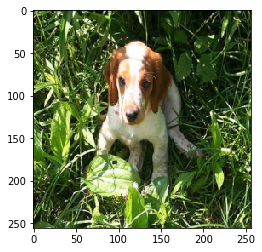

In [24]:
plt.imshow(topil(img[0]))

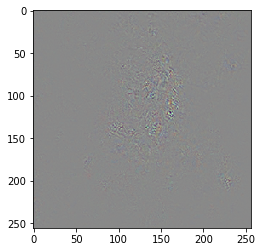

In [21]:
ind = 0
img_grad = (grads[ind] - grads[ind].min())/(grads[ind].max() - grads[ind].min())
plt.imshow(topil(img_grad.cpu()))

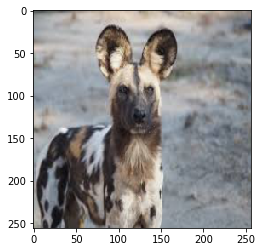

In [25]:
plt.imshow(topil(img[1]))

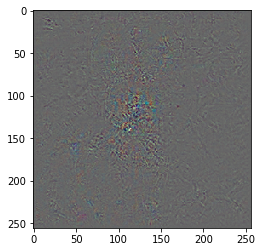

In [26]:
ind = 1
img_grad = (grads[ind] - grads[ind].min())/(grads[ind].max() - grads[ind].min())
plt.imshow(topil(img_grad.cpu()))

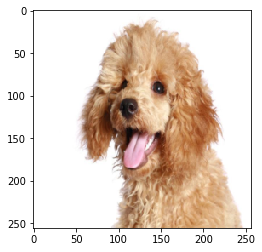

In [27]:
plt.imshow(topil(img[2]))

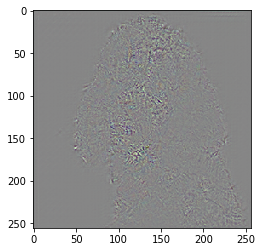

In [28]:
ind = 2
img_grad = (grads[ind] - grads[ind].min())/(grads[ind].max() - grads[ind].min())
plt.imshow(topil(img_grad.cpu()))

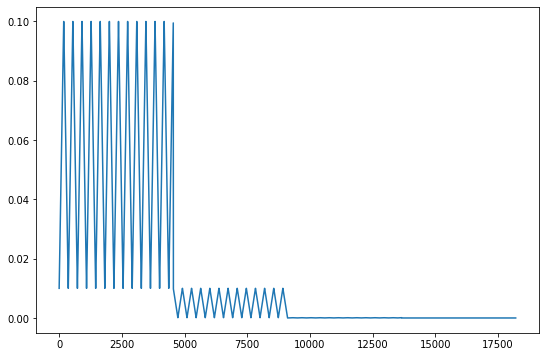

In [68]:
###Learning Rate graph
lrs = []
step = 0

clr = cyclical_lr(2*len(trainloader), min_lr=1e-2, max_lr=1e-1)
epoch = 50
for _ in range(epoch):
    for _ in range(len(trainloader)):
        lrs.append(clr(step))
        step += 1
        
clr = cyclical_lr(2*len(trainloader), min_lr=1e-4, max_lr=1e-2)
epoch = 50
for _ in range(epoch):
    for _ in range(len(trainloader)):
        lrs.append(clr(step))
        step += 1
        
clr = cyclical_lr(2*len(trainloader), min_lr=1e-6, max_lr=1e-4)
epoch = 50
for _ in range(epoch):
    for _ in range(len(trainloader)):
        lrs.append(clr(step))
        step += 1

clr = cyclical_lr(2*len(trainloader), min_lr=1e-10, max_lr=1e-6)
epoch = 50
for _ in range(epoch):
    for _ in range(len(trainloader)):
        lrs.append(clr(step))
        step += 1
        
plt.figure(figsize=(9, 6))
plt.plot(range(200 * len(trainloader)), lrs)
plt.show()

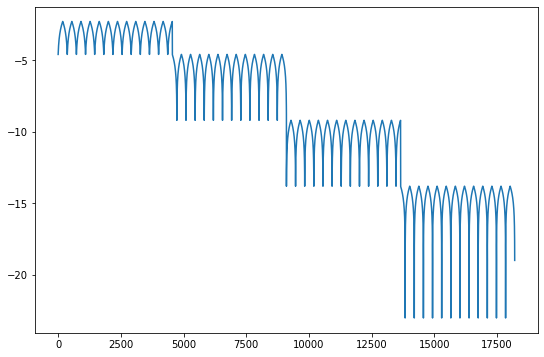

In [69]:
plt.figure(figsize=(9, 6))
plt.plot(range(200 * len(trainloader)), [np.log(x) for x in lrs])
plt.show()